<a href="https://colab.research.google.com/github/eli2k3/CSE469Blockchain/blob/main/Copy_of_CSE_572_Natural_Language_Disaster_Term_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nlp_getting_started_path = kagglehub.competition_download('nlp-getting-started')

print('Data source import complete.')


100%|██████████| 593k/593k [00:00<00:00, 73.4MB/s]

Extracting files...
Data source import complete.


### **1. Import Necessary Libraries**


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from wordcloud import WordCloud
from gensim.models import Word2Vec
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

### **2. Load and Inspect Dataset**

In [ ]:
# List all files in input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load the dataset
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

# Display basic information
df_train.info()
df_test.info()

# Show first few rows
df_train.head()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### **3. Data Exploration**

<ipython-input-7-d7c0081a8ec0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_train["target"], palette="coolwarm")


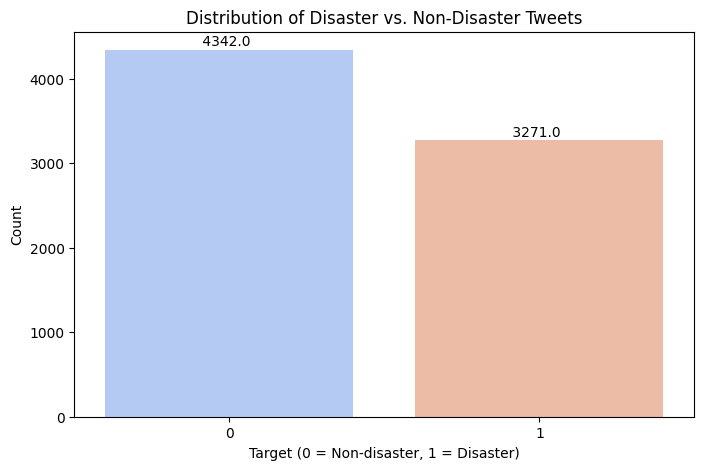

In [ ]:
# Plot distribution of target labels with percentage labels
plt.figure(figsize=(8,5))
sns.countplot(x=df_train["target"], palette="coolwarm")
plt.title("Distribution of Disaster vs. Non-Disaster Tweets")
plt.xlabel("Target (0 = Non-disaster, 1 = Disaster)")
plt.ylabel("Count")
for p in plt.gca().patches:
    plt.gca().annotate(f' {p.get_height()}', (p.get_x() + 0.3, p.get_height() + 50))
plt.show()

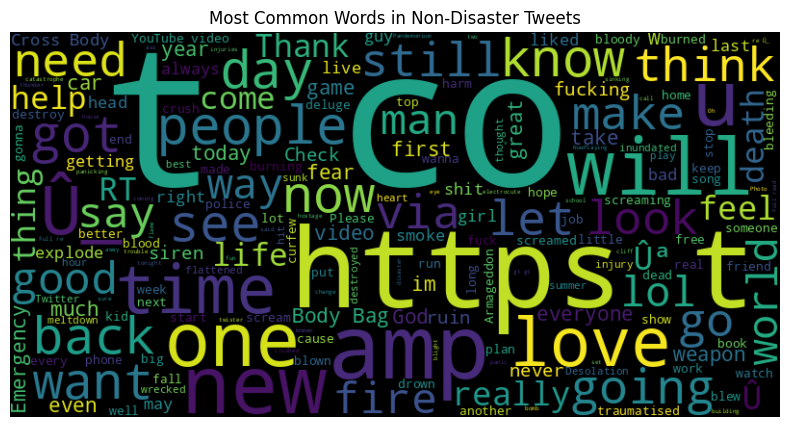

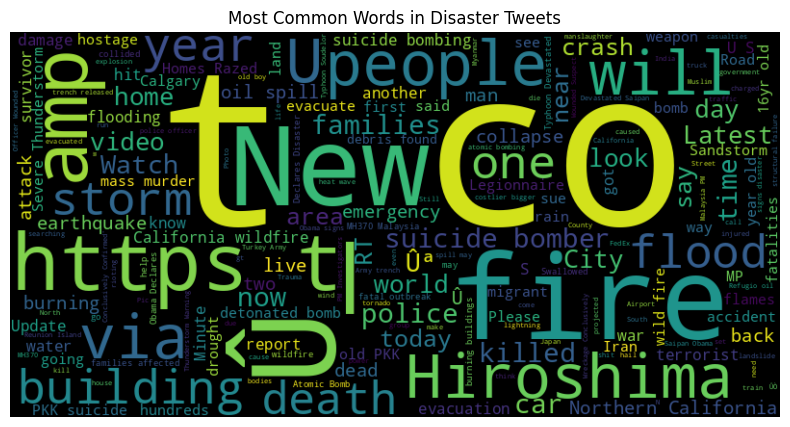

In [ ]:
# Plot word cloud for non-disaster tweets
non_disaster_tweets = " ".join(df_train[df_train['target'] == 0]['text'])
wordcloud_non = WordCloud(width=800, height=400, max_words=200, background_color='black').generate(non_disaster_tweets)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Non-Disaster Tweets")
plt.show()

# Check missing values
df_train.isnull().sum()
df_test.isnull().sum()

# Generate word cloud for disaster tweets
disaster_tweets = " ".join(df_train[df_train['target'] == 1]['text'])
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='black').generate(disaster_tweets)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Disaster Tweets")
plt.show()

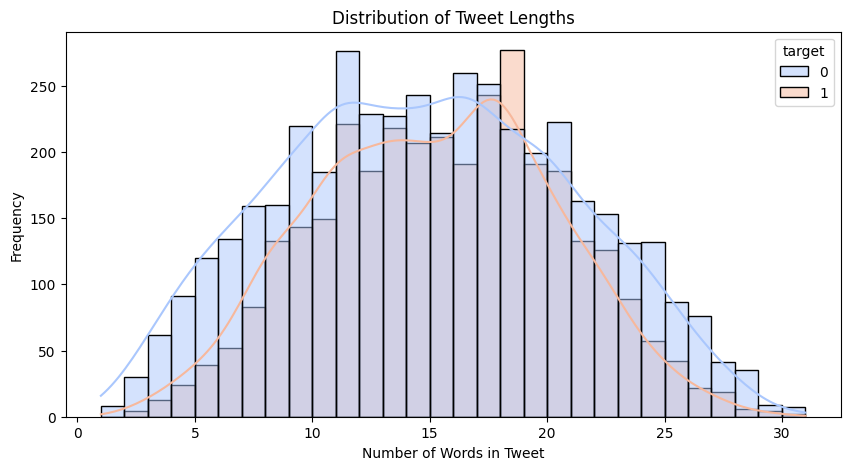

In [ ]:
df_train["text_length"] = df_train["text"].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(df_train, x="text_length", hue="target", bins=30, kde=True, palette="coolwarm")
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Number of Words in Tweet")
plt.ylabel("Frequency")
plt.show()

<ipython-input-15-18ea3fe82e5e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="coolwarm")


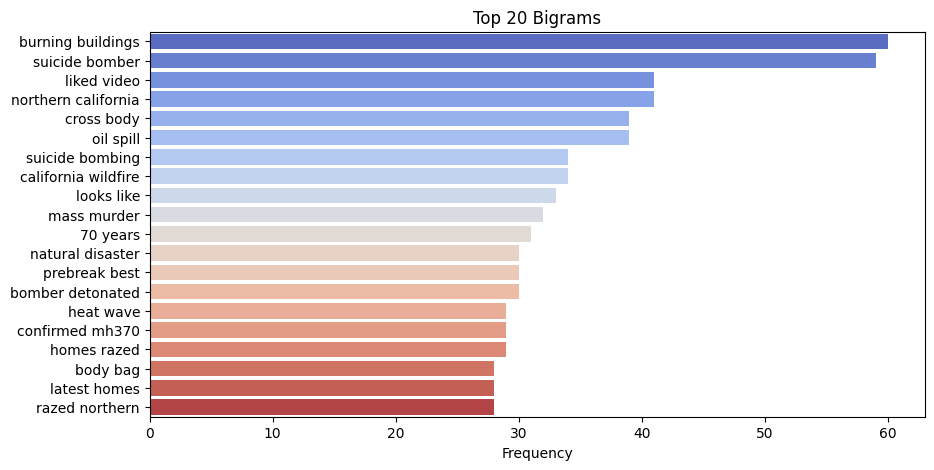

<ipython-input-15-18ea3fe82e5e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="coolwarm")


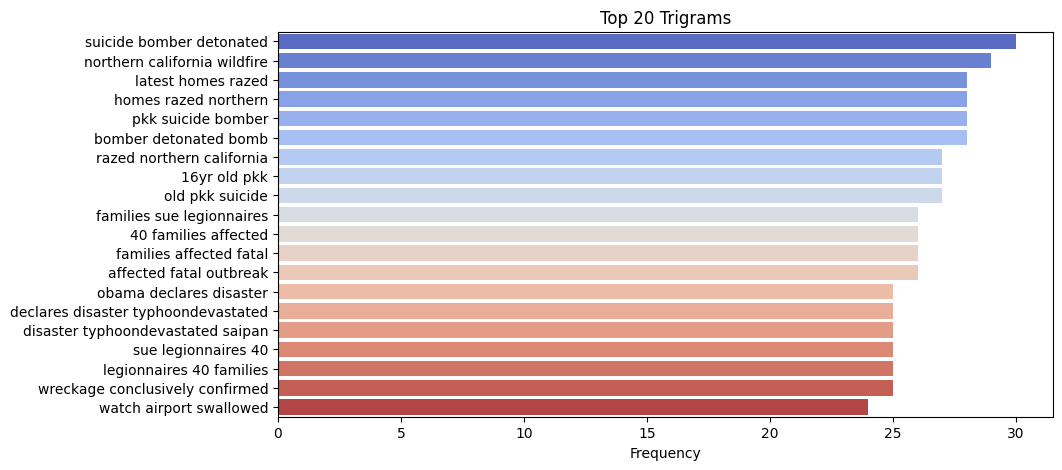

In [ ]:
def plot_ngrams(text_series, n=2, num_ngrams=20):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(text_series)
    bag_of_words = vec.transform(text_series)
    sum_words = bag_of_words.sum(axis=0)

    word_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)[:num_ngrams]

    words, counts = zip(*word_freq)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), palette="coolwarm")
    plt.title(f"Top {num_ngrams} {'Bigrams' if n==2 else 'Trigrams'}")
    plt.xlabel("Frequency")
    plt.show()

# Plot for bigrams
plot_ngrams(df_train["clean_text"], n=2)

# Plot for trigrams
plot_ngrams(df_train["clean_text"], n=3)

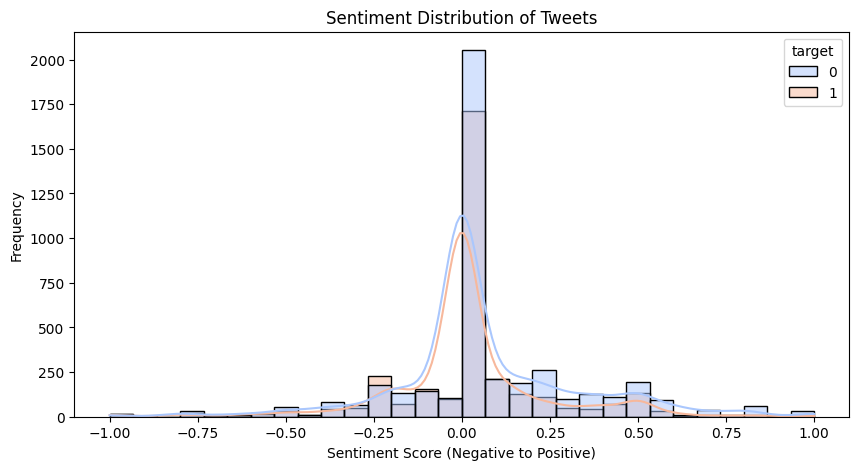

In [ ]:
df_train["sentiment"] = df_train["clean_text"].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 5))
sns.histplot(df_train, x="sentiment", hue="target", bins=30, kde=True, palette="coolwarm")
plt.title("Sentiment Distribution of Tweets")
plt.xlabel("Sentiment Score (Negative to Positive)")
plt.ylabel("Frequency")
plt.show()

<Figure size 1200x600 with 0 Axes>

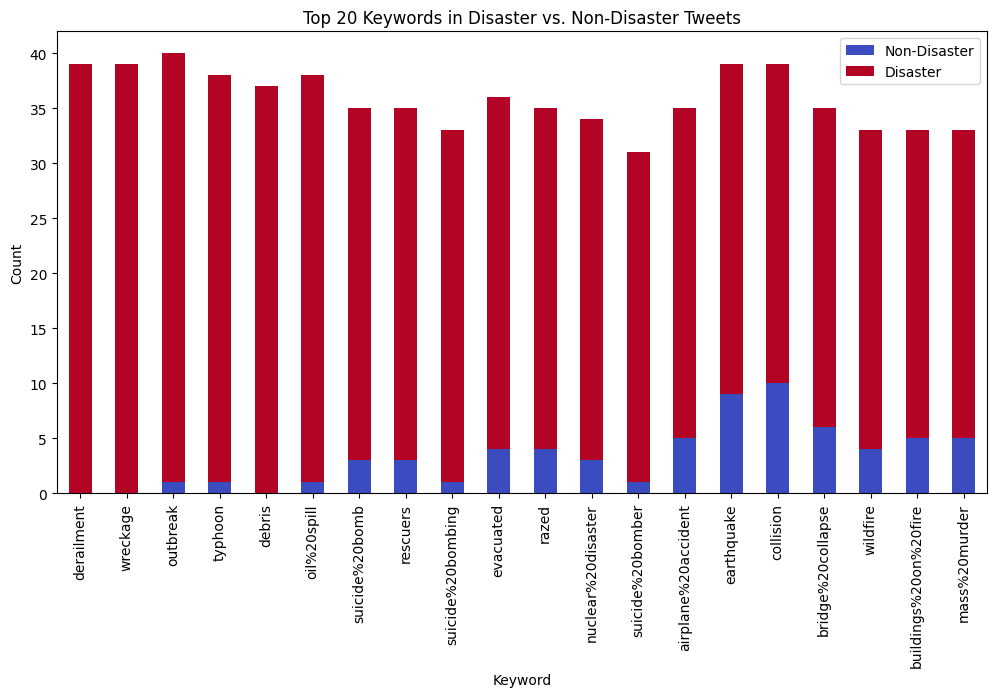

In [ ]:
plt.figure(figsize=(12, 6))
df_train.groupby("keyword")["target"].value_counts().unstack().fillna(0).sort_values(1, ascending=False)[:20].plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(12,6))
plt.title("Top 20 Keywords in Disaster vs. Non-Disaster Tweets")
plt.xlabel("Keyword")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Non-Disaster", "Disaster"])
plt.show()

### **4. Text Preprocessing**

In [ ]:
# Function to clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text) # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text) # Remove mentions and hashtags
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = " ".join(text.split()) # Remove extra spaces
    return text

# Apply text cleaning
df_train["clean_text"] = df_train["text"].apply(clean_text)
df_test["clean_text"] = df_test["text"].apply(clean_text)

# Display cleaned text samples
df_train[["text", "clean_text"]].head()


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


<ipython-input-14-5edc9bc124ec>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="coolwarm")


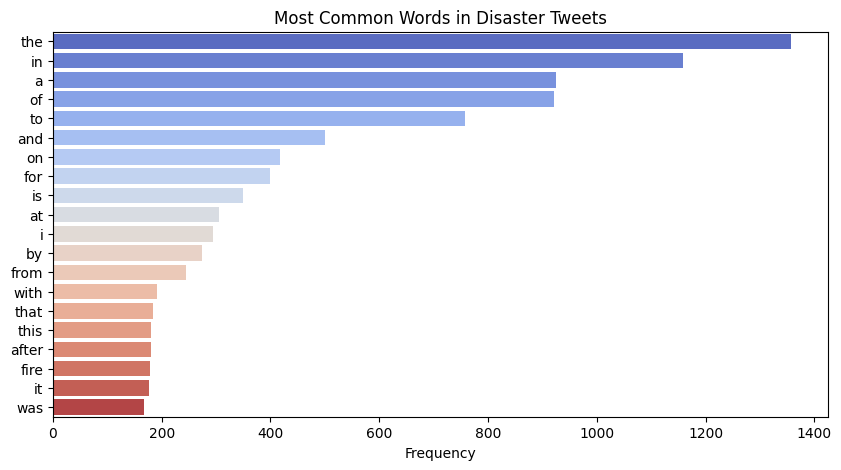

<ipython-input-14-5edc9bc124ec>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="coolwarm")


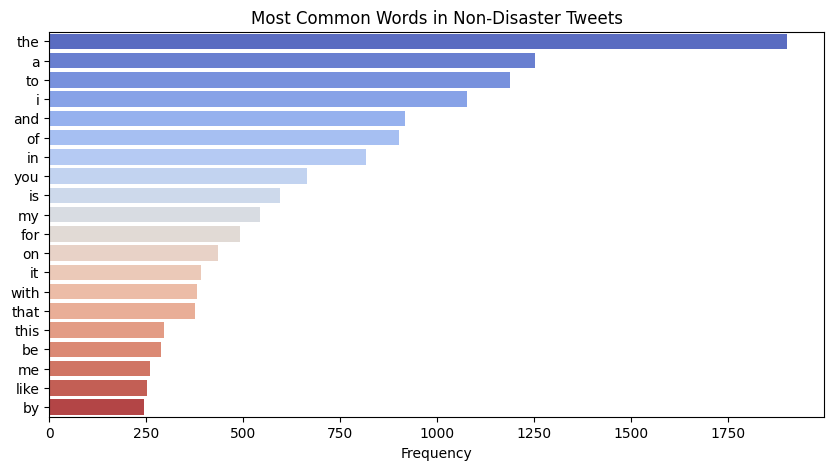

In [ ]:
# Get most common words for disaster and non-disaster tweets
def plot_most_common_words(text_series, title, num_words=20):
    all_words = " ".join(text_series).split()
    word_counts = Counter(all_words)
    common_words = word_counts.most_common(num_words)

    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), palette="coolwarm")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.show()

# Plot for disaster tweets
plot_most_common_words(df_train[df_train['target'] == 1]['clean_text'], "Most Common Words in Disaster Tweets")

# Plot for non-disaster tweets
plot_most_common_words(df_train[df_train['target'] == 0]['clean_text'], "Most Common Words in Non-Disaster Tweets")


### **5. Feature Extraction using TF-IDF & Word2Vec**

In [ ]:
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2)) # Use unigrams and bigrams
X_train_tfidf = vectorizer.fit_transform(df_train["clean_text"])
X_test_tfidf = vectorizer.transform(df_test["clean_text"])

# Train Word2Vec model
sentences = [row.split() for row in df_train["clean_text"]]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

def get_w2v_features(text, model, vector_size=100):
    words = text.split()
    vector = np.zeros(vector_size)
    valid_words = [word for word in words if word in model.wv]
    if valid_words:
        vector = np.mean([model.wv[word] for word in valid_words], axis=0)
    return vector

X_train_w2v = np.array([get_w2v_features(text, w2v_model) for text in df_train["clean_text"]])
X_test_w2v = np.array([get_w2v_features(text, w2v_model) for text in df_test["clean_text"]])

### **6. Train Random Forest Model**

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_tfidf, df_train["target"])
rf_pred = rf_model.predict(X_test_tfidf)

### **7. Generate Predictions for Submission**

Submission file saved as submission.csv


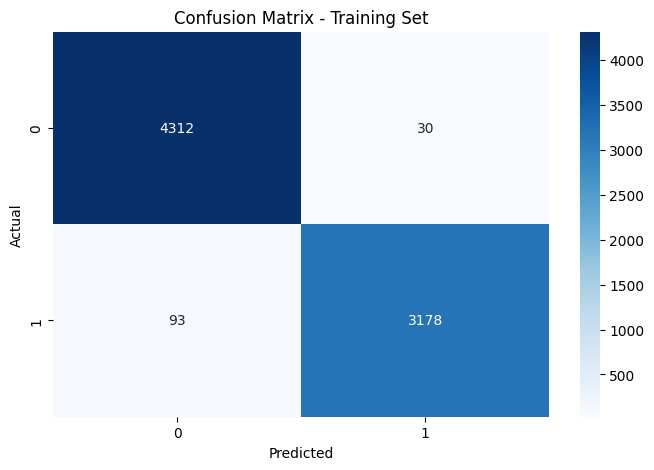

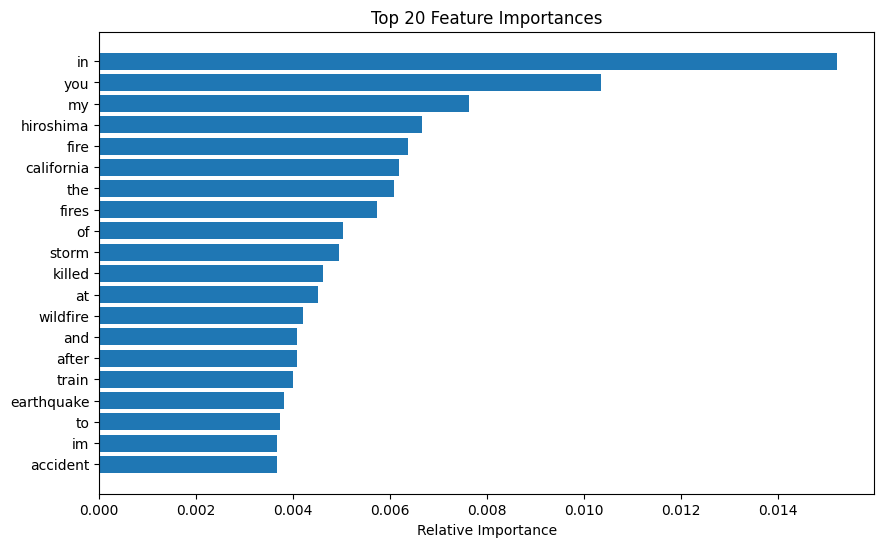

Random Forest Model Performance on Train Set:
Accuracy: 0.9838
Precision: 0.9906
Recall: 0.9716
F1-score: 0.9810



In [ ]:
# Generate predictions for test set
rf_train_pred = rf_model.predict(X_train_tfidf)

# Prepare submission file
submission = pd.DataFrame({
    "id": df_train["id"],
    "target": rf_train_pred
})

# Save submission file
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

# Evaluate model on training set
plt.figure(figsize=(8,5))
sns.heatmap(pd.crosstab(df_train['target'], rf_train_pred, rownames=['Actual'], colnames=['Predicted']), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Training Set")
plt.show()

# Feature Importance Plot
feature_importances = rf_model.feature_importances_
indices = np.argsort(feature_importances)[-20:]
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.barh(range(len(indices)), feature_importances[indices], align="center")
plt.yticks(range(len(indices)), [vectorizer.get_feature_names_out()[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()
rf_train_pred = rf_model.predict(X_train_tfidf)
print("Random Forest Model Performance on Train Set:")
print(f"Accuracy: {accuracy_score(df_train['target'], rf_train_pred):.4f}")
print(f"Precision: {precision_score(df_train['target'], rf_train_pred):.4f}")
print(f"Recall: {recall_score(df_train['target'], rf_train_pred):.4f}")
print(f"F1-score: {f1_score(df_train['target'], rf_train_pred):.4f}\n")

### **8. Future Enhancements**

- Experiment with deep learning models (LSTMs, transformers like BERT)
- Use pre-trained embeddings such as FastText (Using Word2Vec Now)
- Perform hyperparameter tuning using GridSearchCV or RandomizedSearchCV
- Augment dataset to handle class imbalance more effectively
- Implement additional NLP techniques like named entity recognition (NER) and sentiment analysis

### Notes
- Expanded Feature Engineering: Using both unigrams and bigrams in TF-IDF.